## Pre-Processing

In [35]:
from source import data_import
from source.constants import CHANNELS, DEFAULT_PATIENTS
import numpy as np
# import pandas as pd
import modin.pandas as pd

from source.filter_eeg_channels import filter_eeg_channels
from source.calculate_mean_psd import calculate_mean_psd
from source.constants import CHANNELS, FREQUENCY_RANGES
                                            
from sklearn.preprocessing import StandardScaler, minmax_scale, MinMaxScaler

In [36]:
## PARAMETERS ##
SKIP_DATA = False
# either LOAD (SKIP_DATA = True) or SAVE (SKIP_DATA = False) with this filename
data_filename = "processed_data" 

SKIP_FEATURES = False
# either LOAD (SKIP_FEATURES = True) or SAVE (SKIP_FEATURES = False) with this filename
feature_filename = 'extracted_features' 

### DATA ###
# Load Patient Data #
patient_ids = [1,2] # use DEFAULT_PATIENTS for default patients selection
nr_segments=60
segment_duration=1
ictal_segmentation_foo=data_import.preictal_segmentation
interictal_segmentation_foo=data_import.inter_segmentation
channels=CHANNELS
seizure_offset=0

# filter #
exclude_ranges=[[58, 62], [118, 122]]

### FEATURES ###
target_colname = 'target'
PRED_INTERVAL = 6000 # how long should a segment count as preictal in seconds

window_size = 30 # Define the sequence_train window size

In [37]:
if not SKIP_DATA:
    # Load Patient Data
    p_df = data_import.load_segmented_data(patient_ids=patient_ids,
                                            nr_segments=nr_segments,
                                            segment_duration=segment_duration,
                                            ictal_segmentation_foo=data_import.preictal_segmentation,
                                            interictal_segmentation_foo=data_import.inter_segmentation,
                                            channels=channels,
                                            seizure_offset=seizure_offset
                                            )
    
    # Filter
    fit_df = filter_eeg_channels(p_df, CHANNELS, fs=256, exclude_ranges=exclude_ranges, Q=30)
    pd_toconcat = p_df[['epoch', 'segment_id']]
    fit_df = pd.concat(objs=[fit_df, pd_toconcat], axis =1)
    np.save('data/' + data_filename + '.npy', p_df)
    p_df.head()
else:
    p_df = np.load('data/' + data_filename + '.npy', allow_pickle=True)
    p_df = pd.DataFrame(p_df)
    p_df.head

## Feature Extraction

In [38]:
### aggregate Functions for mean psd:
delta = lambda x: calculate_mean_psd(x, frequency_ranges={'Delta' : FREQUENCY_RANGES['Delta']})[x.name]['Delta']
theta = lambda x: calculate_mean_psd(x, frequency_ranges={'Theta' : FREQUENCY_RANGES['Theta']})[x.name]['Theta']
gamma = lambda x: calculate_mean_psd(x, frequency_ranges={'Gamma': FREQUENCY_RANGES['Gamma']})[x.name]['Gamma']

delta_agg = pd.NamedAgg(column='delta', aggfunc=delta)
theta_agg = pd.NamedAgg(column='theta', aggfunc=theta)
gamma_agg = pd.NamedAgg(column='gamma', aggfunc=gamma)

### aggregate mean features:
abs_mean = lambda x: x.apply(abs).mean()
abs_mean_agg = pd.NamedAgg(column='abs_mean', aggfunc=abs_mean)

### aggregate Functions for target:
target_foo = lambda x, pred_interval=PRED_INTERVAL: 0 < x.dt.total_seconds().min() < pred_interval

In [39]:
if not SKIP_FEATURES:
    # aggregate features
    df_features = fit_df.groupby(['epoch', 'segment_id']).agg(
        {C:['std',
            'var',
            #'mean',
            abs_mean_agg,
            delta_agg,
            theta_agg,
            gamma_agg
            ] for C in CHANNELS} | 
        {target_colname: [target_foo]} 
        ) 

    # joining column names with agg functions, but leaving target column
    df_features.columns = ['_'.join(col).strip() for col in df_features.columns.values if target_colname != col[0]] + [target_colname]
    df_features.reset_index(inplace=True)

    # Scaling the features
    num_features= df_features.drop(['epoch','segment_id','target'],axis =1)
    scaler = StandardScaler()
    num_features_scaled = scaler.fit_transform(num_features)

    original_array = np.array(df_features)
    target = original_array[:,-1]
    target = target[:, np.newaxis]
    segseiz_column = original_array[:, 0:2] ## epoch and segment_id
    array_all_scaled = np.concatenate((segseiz_column, num_features_scaled, target), axis=1)
    array_all_scaled.shape

    ### Reshape Array ###
    original_array =np.array(df_features)

    # Extract the epoch column
    epoch_column = original_array[:, 0]

    # Determine the number of epochs (assuming epochs are from 1 to number of segments)
    num_epochs = df_features.epoch.unique()[-1]

    # Determine the number of segments for each epoch
    num_segments = len(df_features.segment_id.unique())  # Assuming there are 30 segments for each epoch

    # Initialize an empty 3D array
    reshaped_array = np.empty((num_epochs,num_segments, array_all_scaled.shape[1]))

    # Reshape the data for each epoch and insert it into the 3D array
    for epoch in range(num_epochs):
        start_idx = epoch * num_segments
        end_idx = (epoch + 1) * num_segments
        reshaped_array[epoch,:, :] = array_all_scaled[start_idx:end_idx,:]

    ### Create Sequence Trains ###
    # Assuming original_data_array has dimensions (batch, sequence, features)
    num_batches, num_sequences, num_features = reshaped_array.shape

    # Calculate the number of augmented batches
    num_augmented_batches = num_sequences - window_size + 1
    print(f"num_augmented_batches: {num_augmented_batches}")

    # Create an empty array for the augmented data
    data = np.zeros((num_batches * num_augmented_batches, window_size, num_features))
    print(f"data.shape: {data.shape}")

    # Iterate through batches
    for batch_idx in range(num_batches):
        # Iterate through sequences to create augmented batches
        for seq_idx in range(num_augmented_batches):
            # Copy the window of data
            data[batch_idx * num_augmented_batches + seq_idx, :, :] = reshaped_array[batch_idx, seq_idx:seq_idx + window_size, :]

    np.save('data/' + feature_filename + '.npy', data)
else:
    data = np.load('data/' + feature_filename + '.npy')

data.shape

FileNotFoundError: [Errno 2] No such file or directory: 'data/extracted_features.npy'

data already loaded in parent notebook
train shape (1519, 30, 62)
validation shape (372, 30, 62)
test shape (496, 30, 62)
Epoch 1/300
16/16 [==============================] - 2s 33ms/step - loss: 0.7031 - accuracy: 0.5945 - val_loss: 0.5625 - val_accuracy: 0.7903
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 0.5439 - accuracy: 0.6952 - val_loss: 0.4828 - val_accuracy: 0.8333
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 0.3932 - accuracy: 0.7762 - val_loss: 0.4210 - val_accuracy: 0.9866
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 0.3171 - accuracy: 0.8492 - val_loss: 0.3148 - val_accuracy: 1.0000
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 0.2263 - accuracy: 0.8947 - val_loss: 0.2513 - val_accuracy: 1.0000
Epoch 6/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1837 - accuracy: 0.9263 - val_loss: 0.1868 - val_accuracy: 0.9812
Epoch 7/300
16/16 [=======

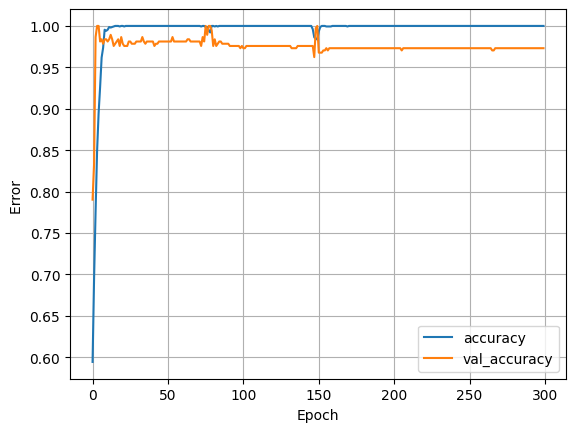

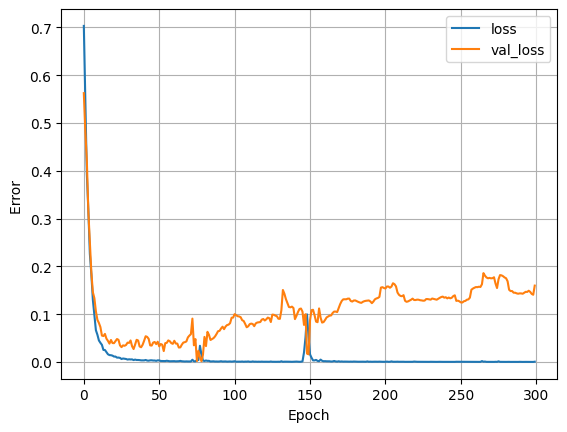

16/16 - 0s - loss: 1.3732 - accuracy: 0.8750 - 46ms/epoch - 3ms/step
Model accuracy: 0.875
16/16 [==============================] - 0s 2ms/step - loss: 1.3732 - accuracy: 0.8750
Loss: 1.3731672763824463
Accuracy: 0.875
Precision: 0.0
Recall: 0.0


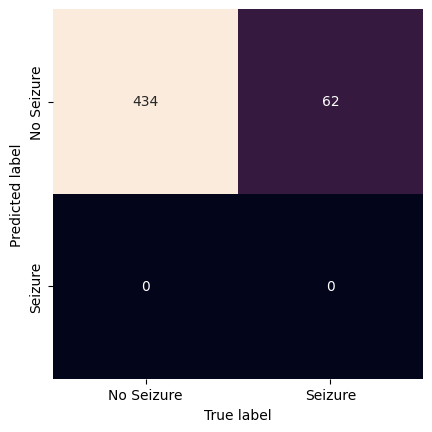

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       434
         1.0       0.00      0.00      0.00        62

    accuracy                           0.88       496
   macro avg       0.44      0.50      0.47       496
weighted avg       0.77      0.88      0.82       496



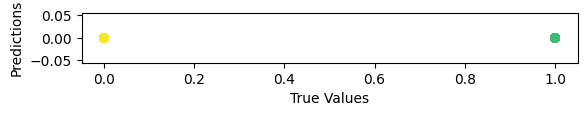

Epoch 1/300
16/16 [==============================] - 1s 14ms/step - loss: 0.6891 - accuracy: 0.5326 - val_loss: 0.2433 - val_accuracy: 0.9113
Epoch 2/300
16/16 [==============================] - 0s 5ms/step - loss: 0.5298 - accuracy: 0.6972 - val_loss: 0.2337 - val_accuracy: 0.9301
Epoch 3/300
16/16 [==============================] - 0s 5ms/step - loss: 0.4657 - accuracy: 0.7202 - val_loss: 0.2307 - val_accuracy: 0.9516
Epoch 4/300
16/16 [==============================] - 0s 5ms/step - loss: 0.4109 - accuracy: 0.8012 - val_loss: 0.2009 - val_accuracy: 0.9597
Epoch 5/300
16/16 [==============================] - 0s 6ms/step - loss: 0.3563 - accuracy: 0.8473 - val_loss: 0.1732 - val_accuracy: 0.9677
Epoch 6/300
16/16 [==============================] - 0s 5ms/step - loss: 0.3078 - accuracy: 0.8736 - val_loss: 0.1543 - val_accuracy: 0.9651
Epoch 7/300
16/16 [==============================] - 0s 5ms/step - loss: 0.2701 - accuracy: 0.8940 - val_loss: 0.1129 - val_accuracy: 0.9597
Epoch 8/300


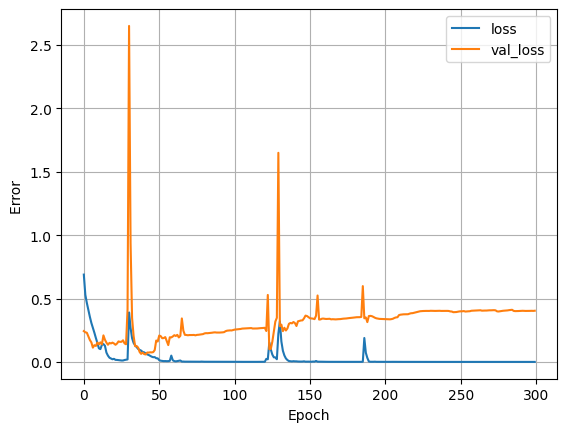

16/16 [==============================] - 0s 2ms/step
16/16 - 0s - loss: 1.1351 - accuracy: 0.8750 - 30ms/epoch - 2ms/step
Model accuracy: 0.875
16/16 [==============================] - 0s 1ms/step - loss: 1.1351 - accuracy: 0.8750
Loss: 1.1351393461227417
Accuracy: 0.875
Precision: 0.0
Recall: 0.0


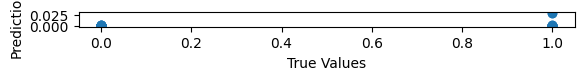

In [ ]:
data = augmented_data_array
%run model_rnn.ipynb